In [55]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [38]:
import os
import matplotlib.pyplot as plt
import cv2

resnet50 50ep - 19:36
RESNET50 100 ep 38:57
facecnn 50 ep - 18:07
SimpleMLP - 16:25

In [39]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [40]:
TARGET_DIR = "data/train"
TARGET_VAL_DIR = "data/val"
TARGET_TEST_DIR ="data/test"

MODELS_DIR = "drive"

In [41]:
len(os.listdir(TARGET_DIR+"/target_person"))

1668

In [42]:
pictures = os.listdir(f"{TARGET_DIR}/target_person")
pictures = pictures[1:]
# pictures

In [43]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_HEIGHT, IMG_WIDTH = 170, 220
BATCH_SIZE = 32

train_tfms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    # transforms.RandomHorizontalFlip(p=0.5),   
    transforms.RandomVerticalFlip(p=0.5),     
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

mapping =  {"target_person": 1, "non_target_person": 0}
train_dataset = datasets.ImageFolder("data/train", transform=train_tfms)
train_dataset.class_to_idx = mapping

val_dataset   = datasets.ImageFolder("data/val", transform=val_tfms)
val_dataset.class_to_idx = mapping

test_dataset = datasets.ImageFolder("data/test", transform=val_tfms)
val_dataset.class_to_idx = mapping

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        input_dim = 3 * IMG_HEIGHT * IMG_WIDTH  
        hidden_dim = 512

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 128)
        self.fc3 = nn.Linear(128, 1)  # single output (logit)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation here
        return x


In [20]:
model = SimpleMLP().to(device)
summary(model, (3, 170, 220))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]      57,446,912
            Linear-2                  [-1, 128]          65,664
            Linear-3                    [-1, 1]             129
Total params: 57,512,705
Trainable params: 57,512,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.43
Forward/backward pass size (MB): 0.00
Params size (MB): 219.39
Estimated Total Size (MB): 219.83
----------------------------------------------------------------


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm

model = SimpleMLP().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_accuracy = best_recall = best_precision = best_f1 = 0.0
EPOCHS = 50

train_losses, train_accs = [], []
val_accuracies, val_recalls, val_precisions, val_f1s = [], [], [], []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # BCE expects shape (B,1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_labels, val_preds = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    val_accuracies.append(val_accuracy)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)
    val_f1s.append(val_f1)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_accuracy_model_simpleMLP.pth")
    if val_recall > best_recall:
        best_recall = val_recall
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_recall_model_simpleMLP.pth")
    if val_precision > best_precision:
        best_precision = val_precision
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_precision_model_simpleMLP.pth")
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_f1_model_simpleMLP.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_accuracy:.2f} | "
          f"Val Recall: {val_recall:.2f} | Val Precision: {val_precision:.2f} | Val F1: {val_f1:.2f}")


  2%|█▋                                                                                  | 1/50 [00:19<16:08, 19.77s/it]

Epoch 1/50 | Loss: 0.3100 | Train Acc: 0.87% | Val Acc: 0.88 | Val Recall: 0.69 | Val Precision: 0.93 | Val F1: 0.79


  4%|███▎                                                                                | 2/50 [00:40<16:24, 20.50s/it]

Epoch 2/50 | Loss: 0.1973 | Train Acc: 0.92% | Val Acc: 0.94 | Val Recall: 0.94 | Val Precision: 0.89 | Val F1: 0.91


  6%|█████                                                                               | 3/50 [01:01<16:02, 20.48s/it]

Epoch 3/50 | Loss: 0.1472 | Train Acc: 0.95% | Val Acc: 0.95 | Val Recall: 0.89 | Val Precision: 0.96 | Val F1: 0.93


  8%|██████▋                                                                             | 4/50 [01:20<15:27, 20.17s/it]

Epoch 4/50 | Loss: 0.1225 | Train Acc: 0.95% | Val Acc: 0.95 | Val Recall: 0.95 | Val Precision: 0.91 | Val F1: 0.93


 10%|████████▍                                                                           | 5/50 [01:40<15:05, 20.12s/it]

Epoch 5/50 | Loss: 0.1330 | Train Acc: 0.95% | Val Acc: 0.94 | Val Recall: 0.88 | Val Precision: 0.94 | Val F1: 0.91


 12%|██████████                                                                          | 6/50 [02:01<14:46, 20.15s/it]

Epoch 6/50 | Loss: 0.1031 | Train Acc: 0.96% | Val Acc: 0.95 | Val Recall: 0.95 | Val Precision: 0.91 | Val F1: 0.93


 14%|███████████▊                                                                        | 7/50 [02:21<14:31, 20.27s/it]

Epoch 7/50 | Loss: 0.0879 | Train Acc: 0.97% | Val Acc: 0.96 | Val Recall: 0.94 | Val Precision: 0.94 | Val F1: 0.94


 16%|█████████████▍                                                                      | 8/50 [02:41<14:03, 20.08s/it]

Epoch 8/50 | Loss: 0.1001 | Train Acc: 0.96% | Val Acc: 0.92 | Val Recall: 0.80 | Val Precision: 0.96 | Val F1: 0.87


 18%|███████████████                                                                     | 9/50 [03:01<13:46, 20.15s/it]

Epoch 9/50 | Loss: 0.0981 | Train Acc: 0.97% | Val Acc: 0.97 | Val Recall: 0.95 | Val Precision: 0.96 | Val F1: 0.96


 20%|████████████████▌                                                                  | 10/50 [03:21<13:18, 19.96s/it]

Epoch 10/50 | Loss: 0.0758 | Train Acc: 0.97% | Val Acc: 0.96 | Val Recall: 0.94 | Val Precision: 0.96 | Val F1: 0.95


 22%|██████████████████▎                                                                | 11/50 [03:41<13:00, 20.02s/it]

Epoch 11/50 | Loss: 0.0615 | Train Acc: 0.98% | Val Acc: 0.96 | Val Recall: 0.94 | Val Precision: 0.95 | Val F1: 0.95


 24%|███████████████████▉                                                               | 12/50 [04:00<12:36, 19.90s/it]

Epoch 12/50 | Loss: 0.0722 | Train Acc: 0.98% | Val Acc: 0.96 | Val Recall: 0.94 | Val Precision: 0.94 | Val F1: 0.94


 26%|█████████████████████▌                                                             | 13/50 [04:20<12:15, 19.88s/it]

Epoch 13/50 | Loss: 0.0511 | Train Acc: 0.98% | Val Acc: 0.96 | Val Recall: 0.95 | Val Precision: 0.94 | Val F1: 0.94


 28%|███████████████████████▏                                                           | 14/50 [04:39<11:46, 19.64s/it]

Epoch 14/50 | Loss: 0.0551 | Train Acc: 0.98% | Val Acc: 0.96 | Val Recall: 0.95 | Val Precision: 0.93 | Val F1: 0.94


 30%|████████████████████████▉                                                          | 15/50 [04:59<11:24, 19.55s/it]

Epoch 15/50 | Loss: 0.0645 | Train Acc: 0.98% | Val Acc: 0.95 | Val Recall: 0.90 | Val Precision: 0.96 | Val F1: 0.93


 32%|██████████████████████████▌                                                        | 16/50 [05:18<10:57, 19.34s/it]

Epoch 16/50 | Loss: 0.0469 | Train Acc: 0.98% | Val Acc: 0.97 | Val Recall: 0.95 | Val Precision: 0.95 | Val F1: 0.95


 34%|████████████████████████████▏                                                      | 17/50 [05:37<10:43, 19.49s/it]

Epoch 17/50 | Loss: 0.0459 | Train Acc: 0.98% | Val Acc: 0.97 | Val Recall: 0.95 | Val Precision: 0.95 | Val F1: 0.95


 36%|█████████████████████████████▉                                                     | 18/50 [05:57<10:26, 19.59s/it]

Epoch 18/50 | Loss: 0.0571 | Train Acc: 0.98% | Val Acc: 0.93 | Val Recall: 0.85 | Val Precision: 0.94 | Val F1: 0.90


 38%|███████████████████████████████▌                                                   | 19/50 [06:18<10:16, 19.89s/it]

Epoch 19/50 | Loss: 0.0362 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.97 | Val Precision: 0.95 | Val F1: 0.96


 40%|█████████████████████████████████▏                                                 | 20/50 [06:38<09:55, 19.84s/it]

Epoch 20/50 | Loss: 0.0283 | Train Acc: 0.99% | Val Acc: 0.96 | Val Recall: 0.97 | Val Precision: 0.92 | Val F1: 0.95


 42%|██████████████████████████████████▊                                                | 21/50 [06:58<09:36, 19.88s/it]

Epoch 21/50 | Loss: 0.0316 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.97 | Val Precision: 0.93 | Val F1: 0.95


 44%|████████████████████████████████████▌                                              | 22/50 [07:17<09:16, 19.87s/it]

Epoch 22/50 | Loss: 0.0328 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.97 | Val Precision: 0.94 | Val F1: 0.95


 46%|██████████████████████████████████████▏                                            | 23/50 [07:38<08:59, 19.99s/it]

Epoch 23/50 | Loss: 0.0266 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.96 | Val Precision: 0.94 | Val F1: 0.95


 48%|███████████████████████████████████████▊                                           | 24/50 [07:58<08:39, 19.97s/it]

Epoch 24/50 | Loss: 0.0350 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.96 | Val Precision: 0.95 | Val F1: 0.96


 50%|█████████████████████████████████████████▌                                         | 25/50 [08:17<08:15, 19.81s/it]

Epoch 25/50 | Loss: 0.0353 | Train Acc: 0.99% | Val Acc: 0.96 | Val Recall: 0.95 | Val Precision: 0.93 | Val F1: 0.94


 52%|███████████████████████████████████████████▏                                       | 26/50 [08:36<07:52, 19.68s/it]

Epoch 26/50 | Loss: 0.0740 | Train Acc: 0.97% | Val Acc: 0.96 | Val Recall: 0.95 | Val Precision: 0.94 | Val F1: 0.95


 54%|████████████████████████████████████████████▊                                      | 27/50 [08:56<07:31, 19.61s/it]

Epoch 27/50 | Loss: 0.0417 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.94 | Val Precision: 0.97 | Val F1: 0.95


 56%|██████████████████████████████████████████████▍                                    | 28/50 [09:15<07:11, 19.60s/it]

Epoch 28/50 | Loss: 0.0503 | Train Acc: 0.98% | Val Acc: 0.95 | Val Recall: 0.89 | Val Precision: 0.96 | Val F1: 0.93


 58%|████████████████████████████████████████████████▏                                  | 29/50 [09:34<06:46, 19.34s/it]

Epoch 29/50 | Loss: 0.0436 | Train Acc: 0.98% | Val Acc: 0.94 | Val Recall: 0.99 | Val Precision: 0.85 | Val F1: 0.91


 60%|█████████████████████████████████████████████████▊                                 | 30/50 [09:53<06:26, 19.31s/it]

Epoch 30/50 | Loss: 0.0253 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.94 | Val Precision: 0.98 | Val F1: 0.96


 62%|███████████████████████████████████████████████████▍                               | 31/50 [10:12<06:02, 19.09s/it]

Epoch 31/50 | Loss: 0.0247 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.97 | Val Precision: 0.94 | Val F1: 0.95


 64%|█████████████████████████████████████████████████████                              | 32/50 [10:32<05:46, 19.25s/it]

Epoch 32/50 | Loss: 0.0331 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.96 | Val Precision: 0.94 | Val F1: 0.95


 66%|██████████████████████████████████████████████████████▊                            | 33/50 [10:52<05:32, 19.55s/it]

Epoch 33/50 | Loss: 0.0685 | Train Acc: 0.98% | Val Acc: 0.97 | Val Recall: 0.95 | Val Precision: 0.97 | Val F1: 0.96


 68%|████████████████████████████████████████████████████████▍                          | 34/50 [11:12<05:16, 19.78s/it]

Epoch 34/50 | Loss: 0.0239 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.95 | Val Precision: 0.95 | Val F1: 0.95


 70%|██████████████████████████████████████████████████████████                         | 35/50 [11:32<04:57, 19.86s/it]

Epoch 35/50 | Loss: 0.0156 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.96 | Val Precision: 0.96 | Val F1: 0.96


 72%|███████████████████████████████████████████████████████████▊                       | 36/50 [11:52<04:38, 19.93s/it]

Epoch 36/50 | Loss: 0.0153 | Train Acc: 0.99% | Val Acc: 0.98 | Val Recall: 0.97 | Val Precision: 0.96 | Val F1: 0.97


 74%|█████████████████████████████████████████████████████████████▍                     | 37/50 [12:12<04:20, 20.00s/it]

Epoch 37/50 | Loss: 0.0188 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.94 | Val Precision: 0.97 | Val F1: 0.95


 76%|███████████████████████████████████████████████████████████████                    | 38/50 [12:32<03:59, 19.99s/it]

Epoch 38/50 | Loss: 0.0135 | Train Acc: 1.00% | Val Acc: 0.97 | Val Recall: 0.94 | Val Precision: 0.97 | Val F1: 0.95


 78%|████████████████████████████████████████████████████████████████▋                  | 39/50 [12:52<03:39, 19.91s/it]

Epoch 39/50 | Loss: 0.0260 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.95 | Val Precision: 0.97 | Val F1: 0.96


 80%|██████████████████████████████████████████████████████████████████▍                | 40/50 [13:12<03:19, 19.92s/it]

Epoch 40/50 | Loss: 0.0105 | Train Acc: 1.00% | Val Acc: 0.97 | Val Recall: 0.98 | Val Precision: 0.95 | Val F1: 0.96


 82%|████████████████████████████████████████████████████████████████████               | 41/50 [13:32<02:59, 19.95s/it]

Epoch 41/50 | Loss: 0.0186 | Train Acc: 0.99% | Val Acc: 0.95 | Val Recall: 0.87 | Val Precision: 0.98 | Val F1: 0.92


 84%|█████████████████████████████████████████████████████████████████████▋             | 42/50 [13:52<02:38, 19.82s/it]

Epoch 42/50 | Loss: 0.0434 | Train Acc: 0.99% | Val Acc: 0.96 | Val Recall: 0.97 | Val Precision: 0.92 | Val F1: 0.94


 86%|███████████████████████████████████████████████████████████████████████▍           | 43/50 [14:11<02:17, 19.69s/it]

Epoch 43/50 | Loss: 0.0411 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.94 | Val Precision: 0.98 | Val F1: 0.96


 88%|█████████████████████████████████████████████████████████████████████████          | 44/50 [14:30<01:55, 19.33s/it]

Epoch 44/50 | Loss: 0.0140 | Train Acc: 1.00% | Val Acc: 0.96 | Val Recall: 0.93 | Val Precision: 0.96 | Val F1: 0.94


 90%|██████████████████████████████████████████████████████████████████████████▋        | 45/50 [14:48<01:35, 19.13s/it]

Epoch 45/50 | Loss: 0.0579 | Train Acc: 0.98% | Val Acc: 0.94 | Val Recall: 0.84 | Val Precision: 0.97 | Val F1: 0.90


 92%|████████████████████████████████████████████████████████████████████████████▎      | 46/50 [15:06<01:15, 18.75s/it]

Epoch 46/50 | Loss: 0.0378 | Train Acc: 0.99% | Val Acc: 0.96 | Val Recall: 0.93 | Val Precision: 0.97 | Val F1: 0.95


 94%|██████████████████████████████████████████████████████████████████████████████     | 47/50 [15:26<00:57, 19.14s/it]

Epoch 47/50 | Loss: 0.0574 | Train Acc: 0.98% | Val Acc: 0.98 | Val Recall: 0.97 | Val Precision: 0.96 | Val F1: 0.97


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 48/50 [15:46<00:38, 19.28s/it]

Epoch 48/50 | Loss: 0.0197 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.96 | Val Precision: 0.96 | Val F1: 0.96


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [16:05<00:19, 19.36s/it]

Epoch 49/50 | Loss: 0.0229 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.96 | Val Precision: 0.95 | Val F1: 0.95


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [16:25<00:00, 19.71s/it]

Epoch 50/50 | Loss: 0.0360 | Train Acc: 0.99% | Val Acc: 0.97 | Val Recall: 0.95 | Val Precision: 0.97 | Val F1: 0.96


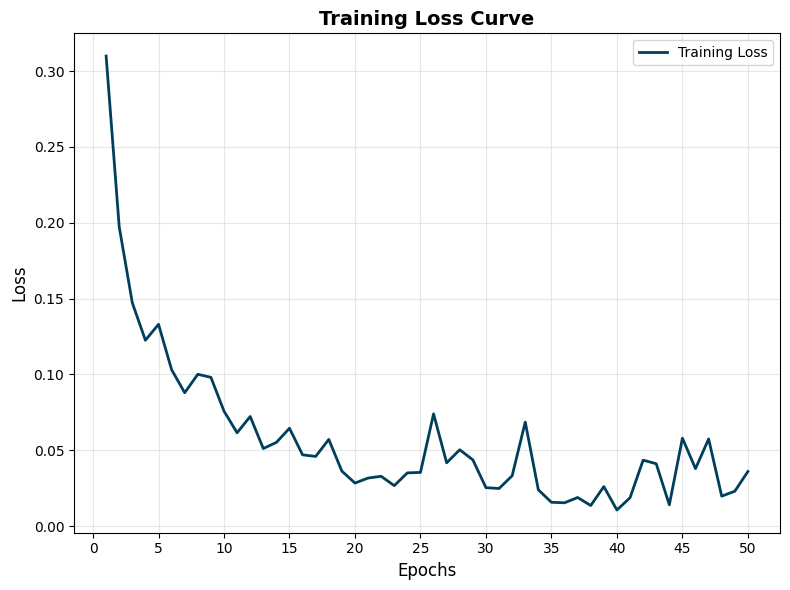

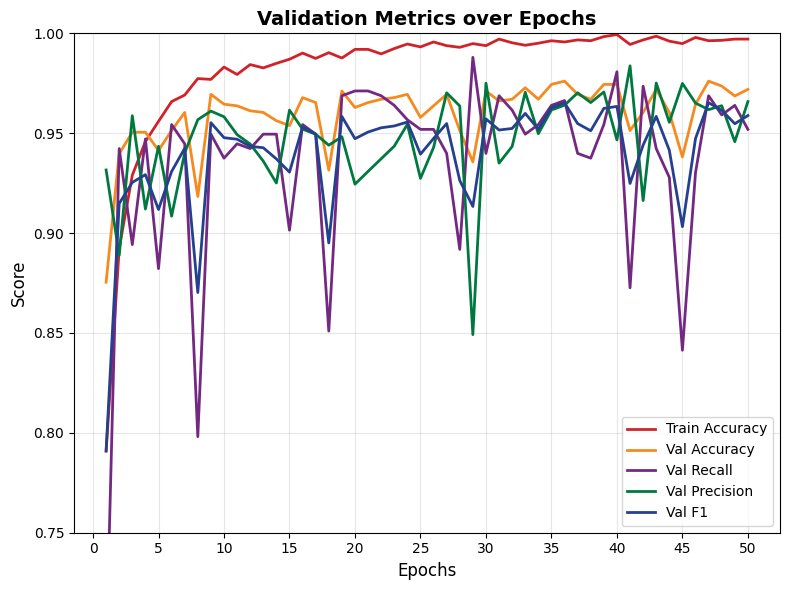

In [ ]:
import matplotlib.pyplot as plt
color_pallette = ["#d12229",
"#f68a1e",
"#fde01a",
"#007940",
"#24408e",
"#732982"
]


colors = {
    'train_loss':'#003f5c',      
    'train_acc': color_pallette[0],       
    'val_acc': color_pallette[1],         
    'val_recall':color_pallette[5],      
    'val_precision':color_pallette[3],   
    'val_f1':color_pallette[4]          
}

# Training Loss
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_losses, color=colors['train_loss'], lw=2, markersize=6, label='Training Loss')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Curve", fontsize=14, fontweight='bold')
plt.xticks(range(0, EPOCHS+1, 5))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("training_loss_curve_MLP.png", dpi=300)
plt.show()


# Accuracy / Recall / F1
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_accuracies, color=colors['train_acc'], lw=2, markersize=6, label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies, color=colors['val_acc'], lw=2, markersize=6, label='Val Accuracy')
plt.plot(range(1, EPOCHS+1), val_recalls, color=colors['val_recall'], lw=2, markersize=6, label='Val Recall')
plt.plot(range(1, EPOCHS+1), val_precisions, color=colors['val_precision'], lw=2, markersize=6, label='Val Precision')
plt.plot(range(1, EPOCHS+1), val_f1s, color=colors['val_f1'], lw=2, markersize=6, label='Val F1')

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Validation Metrics over Epochs", fontsize=14, fontweight='bold')
plt.xticks(range(0, EPOCHS+1, 5))
plt.ylim(0.75, 1)  
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("validation_metrics_curve_MLP.png", dpi=300)
plt.show()


In [28]:
class FaceCNN(nn.Module):
    def __init__(self, num_classes=2, img_height=170, img_width=250):
        super(FaceCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)

        # compute flattened feature size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_height, img_width)  # [N, C, H, W]
            out = self._forward_convs(dummy)
            n_features = out.view(1, -1).size(1)

        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def _forward_convs(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self._forward_convs(x)
        x = x.view(x.size(0), -1)   
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)   

In [18]:
from torchsummary import summary

model = FaceCNN(num_classes=len(train_dataset.classes), 
                img_height=IMG_HEIGHT, img_width=IMG_WIDTH).to(device)
summary(model, (3, 170, 220))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 170, 220]             896
         MaxPool2d-2          [-1, 32, 85, 110]               0
            Conv2d-3          [-1, 64, 85, 110]          18,496
         MaxPool2d-4           [-1, 64, 42, 55]               0
            Conv2d-5          [-1, 128, 42, 55]          73,856
         MaxPool2d-6          [-1, 128, 21, 27]               0
            Conv2d-7          [-1, 256, 21, 27]         295,168
         MaxPool2d-8          [-1, 256, 10, 13]               0
            Linear-9                  [-1, 256]       8,519,936
          Dropout-10                  [-1, 256]               0
           Linear-11                    [-1, 2]             514
Total params: 8,908,866
Trainable params: 8,908,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.43
Forw

In [ ]:
backbone = models.resnet50(pretrained=True)
num_features = backbone.fc.in_features
backbone.fc = nn.Linear(num_features, 2)  # Binary classification
# Freezing backbone layers except classifier
for name, param in backbone.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

model = backbone.to(device)
print(summary(model, (3, 170, 220)))

NameError: name 'models' is not defined

In [11]:
!pip install torchsummary

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [95]:
model = FaceCNN(num_classes=len(train_dataset.classes), 
                img_height=IMG_HEIGHT, img_width=IMG_WIDTH).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [94]:
from tqdm.auto import tqdm

In [54]:
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

In [138]:
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
# import torch
# from tqdm import tqdm

# Track the best metrics
best_recall = 0.0
best_accuracy = 0.0
best_f1 = 0.0
best_precision = 0.0
EPOCHS = 50

# Lists to store history
train_losses = []
train_accuracies = []
val_accuracies = []
val_recalls = []
val_precisions = []
val_f1s = []

model = FaceCNN(num_classes=len(train_dataset.classes), 
                img_height=IMG_HEIGHT, img_width=IMG_WIDTH).to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    train_acc = correct / total
    
    # Save training history
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
    
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    
    val_accuracies.append(val_accuracy)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)
    val_f1s.append(val_f1)
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_accuracy_model_faceCNN.pth")
    
    if val_recall > best_recall:
        best_recall = val_recall
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_recall_model_faceCNN.pth")
    
    if val_precision > best_precision:
        best_precision = val_precision
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_precision_model_faceCNN.pth")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_f1_model_faceCNN.pth")
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_accuracy:.2f} | "
          f"Val Recall: {val_recall:.2f} | Val Precision: {val_precision:.2f} | Val F1: {val_f1:.2f}")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Loss: 0.4595 | Train Acc: 0.79% | Val Acc: 0.90 | Val Recall: 0.88 | Val Precision: 0.85 | Val F1: 0.86
Epoch 2/50 | Loss: 0.2660 | Train Acc: 0.89% | Val Acc: 0.94 | Val Recall: 0.93 | Val Precision: 0.90 | Val F1: 0.91
Epoch 3/50 | Loss: 0.1788 | Train Acc: 0.93% | Val Acc: 0.95 | Val Recall: 0.94 | Val Precision: 0.90 | Val F1: 0.92
Epoch 4/50 | Loss: 0.1436 | Train Acc: 0.95% | Val Acc: 0.94 | Val Recall: 0.96 | Val Precision: 0.88 | Val F1: 0.92
Epoch 5/50 | Loss: 0.1158 | Train Acc: 0.96% | Val Acc: 0.96 | Val Recall: 0.92 | Val Precision: 0.97 | Val F1: 0.94
Epoch 6/50 | Loss: 0.1024 | Train Acc: 0.97% | Val Acc: 0.95 | Val Recall: 0.98 | Val Precision: 0.89 | Val F1: 0.93
Epoch 7/50 | Loss: 0.0863 | Train Acc: 0.97% | Val Acc: 0.97 | Val Recall: 0.94 | Val Precision: 0.98 | Val F1: 0.96
Epoch 8/50 | Loss: 0.0697 | Train Acc: 0.98% | Val Acc: 0.96 | Val Recall: 0.93 | Val Precision: 0.96 | Val F1: 0.94
Epoch 9/50 | Loss: 0.0694 | Train Acc: 0.98% | Val Acc: 0.98 | V

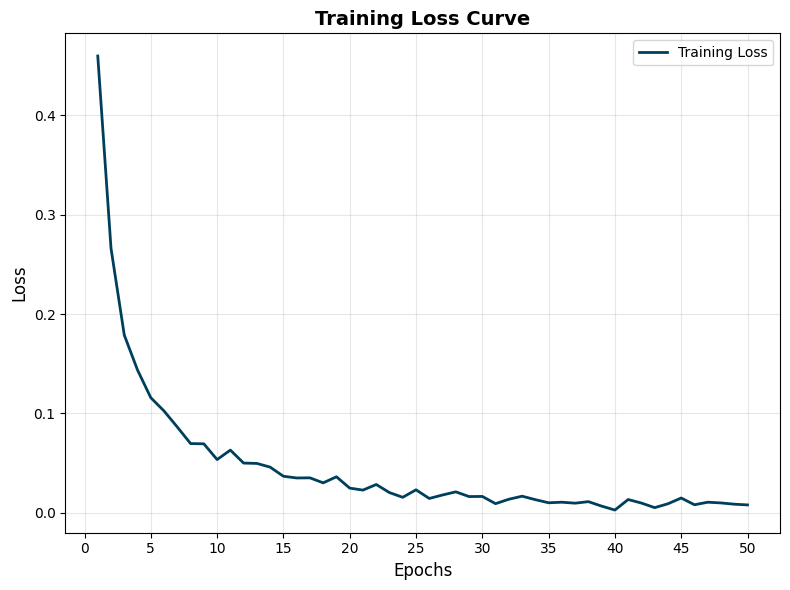

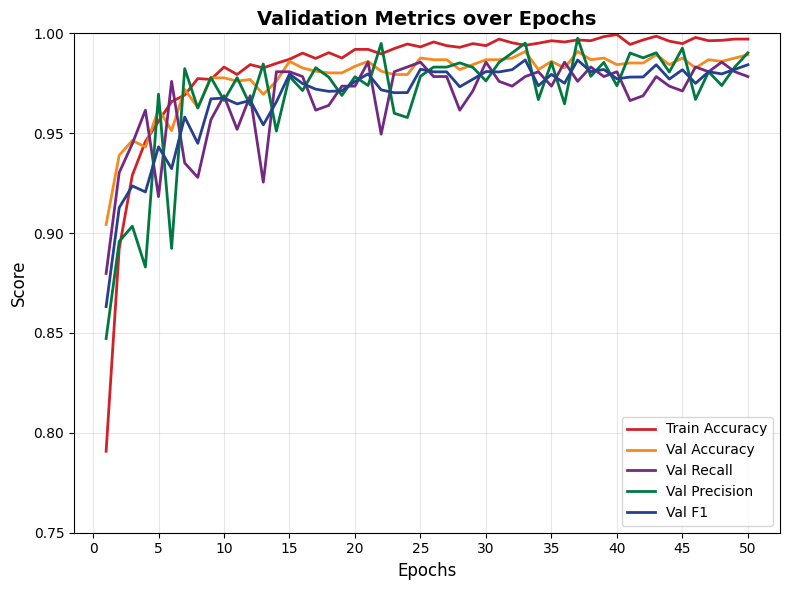

In [140]:
import matplotlib.pyplot as plt
color_pallette = ["#d12229",
"#f68a1e",
"#fde01a",
"#007940",
"#24408e",
"#732982"
]

colors = {
    'train_loss':'#003f5c',    
    'train_acc': color_pallette[0],       
    'val_acc': color_pallette[1],         
    'val_recall':color_pallette[5],      
    'val_precision':color_pallette[3],   
    'val_f1':color_pallette[4]          
}

#Training Loss
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_losses, color=colors['train_loss'], lw=2, markersize=6, label='Training Loss')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Curve", fontsize=14, fontweight='bold')
plt.xticks(range(0, EPOCHS+1, 5))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("training_loss_curve_faceCNN.png", dpi=300)
plt.show()


# Accuracy / Recall / F1 
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_accuracies, color=colors['train_acc'], lw=2, markersize=6, label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies, color=colors['val_acc'], lw=2, markersize=6, label='Val Accuracy')
plt.plot(range(1, EPOCHS+1), val_recalls, color=colors['val_recall'], lw=2, markersize=6, label='Val Recall')
plt.plot(range(1, EPOCHS+1), val_precisions, color=colors['val_precision'], lw=2, markersize=6, label='Val Precision')
plt.plot(range(1, EPOCHS+1), val_f1s, color=colors['val_f1'], lw=2, markersize=6, label='Val F1')

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Validation Metrics over Epochs", fontsize=14, fontweight='bold')
plt.xticks(range(0, EPOCHS+1, 5))
plt.ylim(0.75, 1) 
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("validation_metrics_curve_faceCNN.png", dpi=300)
plt.show()


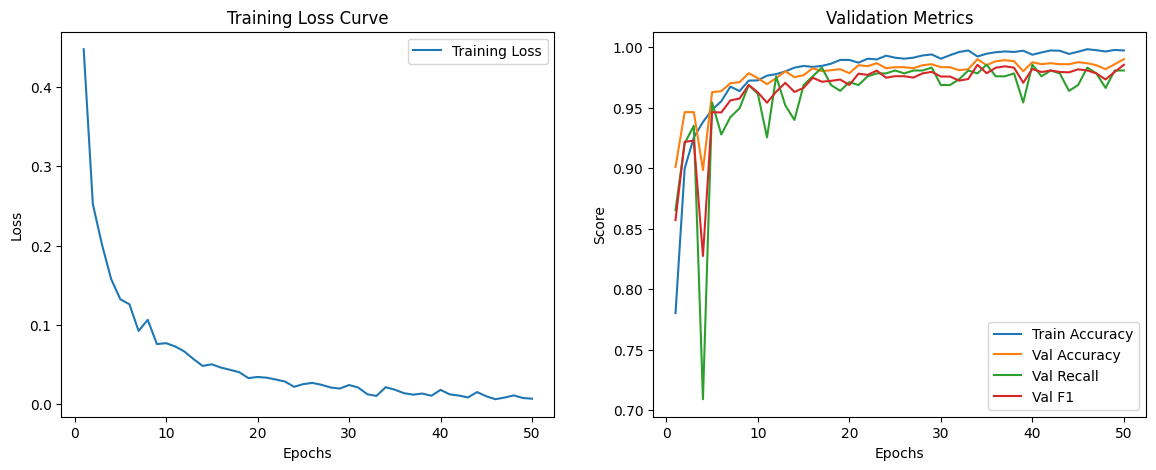

In [111]:
import matplotlib.pyplot as plt 
epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Accuracy / Recall / F1
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.plot(epochs_range, val_recalls, label='Val Recall')
plt.plot(epochs_range, val_f1s, label='Val F1')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.legend()

plt.show()

In [1]:
#testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceCNN(num_classes=2, img_height=170, img_width=220).to(device)
# Load a checkpoint, e.g., best_accuracy_model.pth
model.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_faceCNN.pth", map_location=device))
model.eval()
print("ready to test")


NameError: name 'torch' is not defined

Test Accuracy:  0.7815
Test Recall:    0.6355
Test Precision: 0.9485
Test F1 Score:  0.7611


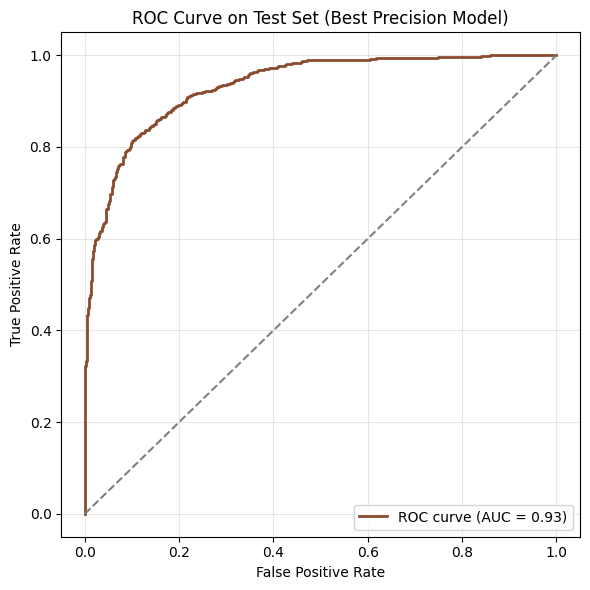

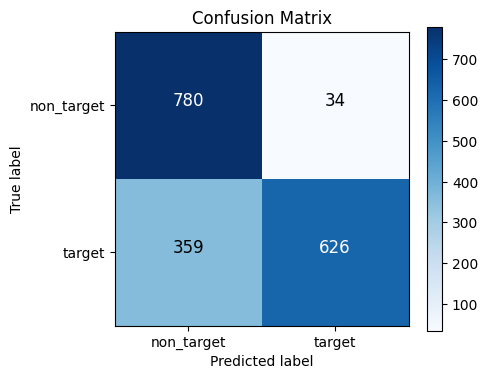

In [ ]:

from sklearn.metrics import confusion_matrix


# model.load_state_dict(torch.load("best_precision_model.pth"))
model.eval()
model.to(device)

#Running on test set
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        probs = torch.softmax(outputs, dim=1)  # get class probabilities
        all_probs.append(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.array(all_labels)

#Predicted labels
y_pred = np.argmax(all_probs, axis=1)

# Metrics 
acc = accuracy_score(all_labels, y_pred)
recall = recall_score(all_labels, y_pred)
precision = precision_score(all_labels, y_pred)
f1 = f1_score(all_labels, y_pred)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

# ROC Curve
y_score = all_probs[:, 1]
fpr, tpr, _ = roc_curve(all_labels, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='#8a4b2e', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set (Best Precision Model)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve_best_precision_faceCNN.png", dpi=300)
plt.show()



# Confusion Matrix 
cm = confusion_matrix(all_labels, y_pred)
classes = ['non_target', 'target']  # adjust if needed

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Annotate counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.tight_layout()
plt.savefig("confusion_matrix_best_precision_faceCNN.png", dpi=300)
plt.show()

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torch.optim import Adam
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from tqdm.auto import tqdm

In [149]:
backbone = models.resnet50(pretrained=True)
num_features = backbone.fc.in_features
backbone.fc = nn.Linear(num_features, 2)  # Binary classification: target vs non-target
LR = 1e-4
EPOCHS = 100
# Freeze backbone layers except classifier
for name, param in backbone.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

model = backbone.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

# ------------------ Training loop ------------------
best_precision = 0.0
best_accuracy = 0.0
best_recall = 0.0 
best_f1 = 0.0
train_losses, train_accs, val_accs, val_recalls, val_precisions, val_f1s = [], [], [], [], [], []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    
    model.eval()
    val_labels, val_preds = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    # saving best model based on metrics
    if val_precision > best_precision:
        best_precision = val_precision
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_precision_model_resnet50_100ep.pth")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_accuracy_model_resnet50_100ep.pth")
    
    if val_recall > best_recall:
        best_recall = val_recall
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_recall_model_resnet50_100ep.pth")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), f"{MODELS_DIR}/best_f1_model_resnet50_100ep.pth")

    # Storing history
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Val Recall: {val_recall:.4f} | Val Precision: {val_precision:.4f} | Val F1: {val_f1:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 | Loss: 0.4922 | Train Acc: 0.7560 | Val Acc: 0.8787 | Val Recall: 0.7524 | Val Precision: 0.8768 | Val F1: 0.8098
Epoch 2/100 | Loss: 0.3331 | Train Acc: 0.8882 | Val Acc: 0.9018 | Val Recall: 0.8510 | Val Precision: 0.8613 | Val F1: 0.8561
Epoch 3/100 | Loss: 0.2754 | Train Acc: 0.9059 | Val Acc: 0.9117 | Val Recall: 0.9038 | Val Precision: 0.8488 | Val F1: 0.8754
Epoch 4/100 | Loss: 0.2413 | Train Acc: 0.9160 | Val Acc: 0.9216 | Val Recall: 0.8750 | Val Precision: 0.8943 | Val F1: 0.8846
Epoch 5/100 | Loss: 0.2208 | Train Acc: 0.9292 | Val Acc: 0.9323 | Val Recall: 0.8870 | Val Precision: 0.9134 | Val F1: 0.9000
Epoch 6/100 | Loss: 0.2125 | Train Acc: 0.9269 | Val Acc: 0.9373 | Val Recall: 0.8846 | Val Precision: 0.9293 | Val F1: 0.9064
Epoch 7/100 | Loss: 0.1993 | Train Acc: 0.9300 | Val Acc: 0.9323 | Val Recall: 0.8942 | Val Precision: 0.9073 | Val F1: 0.9007
Epoch 8/100 | Loss: 0.1877 | Train Acc: 0.9362 | Val Acc: 0.9398 | Val Recall: 0.9159 | Val Precision: 0.9093 |

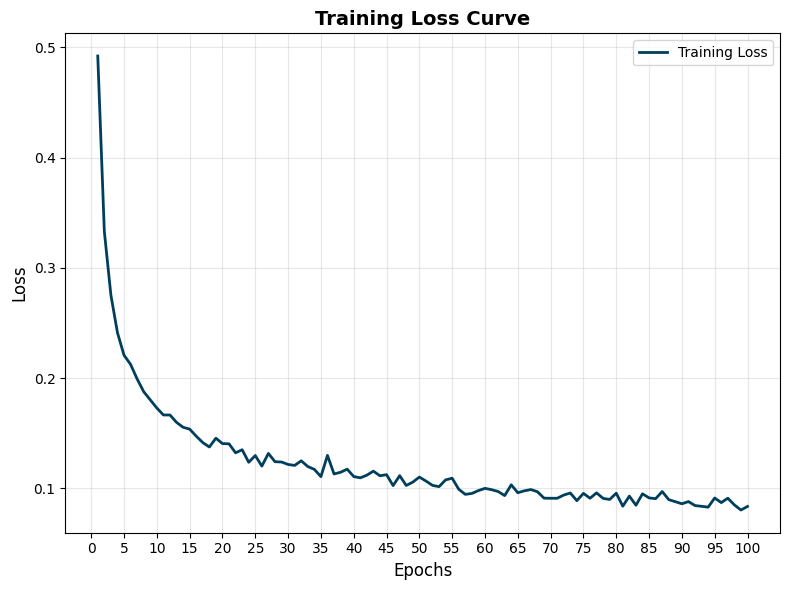

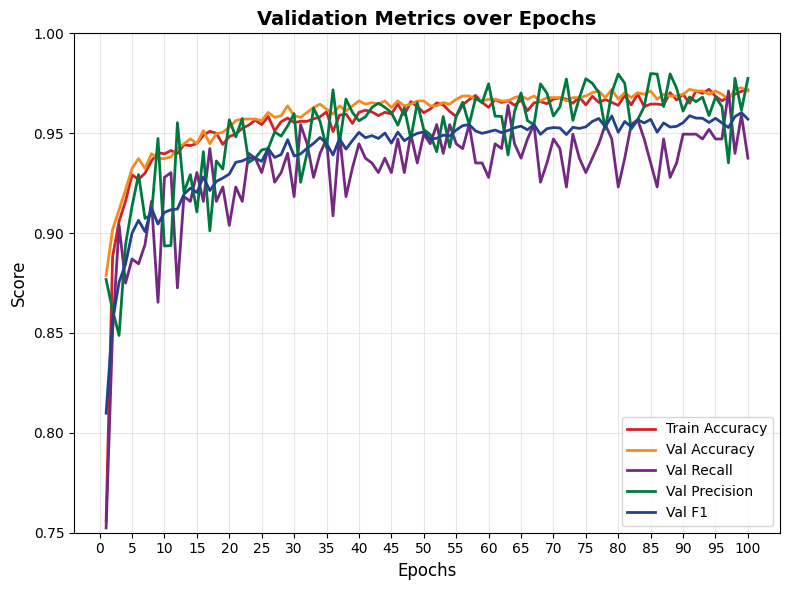

In [ ]:
import matplotlib.pyplot as plt
color_pallette = ["#d12229",
"#f68a1e",
"#fde01a",
"#007940",
"#24408e",
"#732982"
]


colors = {
    'train_loss':'#003f5c',     
    'train_acc': color_pallette[0],   
    'val_acc': color_pallette[1],       
    'val_recall':color_pallette[5],     
    'val_precision':color_pallette[3],  
    'val_f1':color_pallette[4]          
}

#Training loss
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_losses, color=colors['train_loss'], lw=2, markersize=6, label='Training Loss')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Curve", fontsize=14, fontweight='bold')
plt.xticks(range(0, EPOCHS+1, 5))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("training_loss_curve_resnet50_100ep.png", dpi=300)
plt.show()



# Accuracy / Recall / F1 
plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCHS+1), train_accs, color=colors['train_acc'], lw=2, markersize=6, label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accs, color=colors['val_acc'], lw=2, markersize=6, label='Val Accuracy')
plt.plot(range(1, EPOCHS+1), val_recalls, color=colors['val_recall'], lw=2, markersize=6, label='Val Recall')
plt.plot(range(1, EPOCHS+1), val_precisions, color=colors['val_precision'], lw=2, markersize=6, label='Val Precision')
plt.plot(range(1, EPOCHS+1), val_f1s, color=colors['val_f1'], lw=2, markersize=6, label='Val F1')

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Validation Metrics over Epochs", fontsize=14, fontweight='bold')
plt.xticks(range(0, EPOCHS+1, 5))
plt.ylim(0.75, 1)  # Focus on high-performance range
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("validation_metrics_curve_resnet50_100ep.png", dpi=300)
plt.show()

In [ ]:
backbone = models.resnet50(pretrained=True)
num_features = backbone.fc.in_features
backbone.fc = nn.Linear(num_features, 2) 

for name, param in backbone.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

model_resnet = backbone.to(device)

# ------------------ Load saved weights ------------------
model_resnet.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_resnet50_100ep.pth", map_location=device))
model_resnet.eval()  

print("Best precision model loaded successfully!")

Best precision model loaded successfully!


In [52]:

from sklearn.metrics import confusion_matrix

In [51]:

from sklearn.metrics import confusion_matrix

model= backbone.to(device)
model.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_resnet50_100ep.pth", map_location=device))
model.eval()
model.to(device)

all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).to(device)
        
        probs = torch.softmax(outputs, dim=1)  # get class probabilities
        all_probs.append(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.array(all_labels)

y_pred = np.argmax(all_probs, axis=1)

acc = accuracy_score(all_labels, y_pred)
recall = recall_score(all_labels, y_pred)
precision = precision_score(all_labels, y_pred)
f1 = f1_score(all_labels, y_pred)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

# ROC curve
y_score = all_probs[:, 1]
fpr, tpr, _ = roc_curve(all_labels, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='#8a4b2e', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set (Best Recall Model)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve_best_recall.png", dpi=300)
plt.show()



### Confusion Matrix
cm = confusion_matrix(all_labels, y_pred)
classes = ['non_target', 'target']  # adjust if needed

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Annotate counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.tight_layout()
plt.savefig("confusion_matrix_best_recall_resnet50.png", dpi=300)
plt.show()

  1%|▍                                                                                 | 1/181 [00:02<07:03,  2.35s/it]


KeyboardInterrupt: 

In [19]:
!pip install -U scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/c6/99/ed35197a158f1fdc2fe7c3680e9c70d0128f662e1fee4ed495f4b5e13db0/scikit_learn-1.7.2-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.8.0 from https://files.pythonhosted.org/packages/14/c3/61f273ae550fbf1667675701112e380881905e28448c080b23b5a181df7c/scipy-1.16.1-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.8 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 802.6 kB/s eta 0:00:00
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/32/d5/f9a850d79b0851d1d4ef6456097579a9005b31fea68726a4ae5f2d82ddd9/threadpoolctl-3.6.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import random
from torch.utils.data import Subset

embedding_backbone = models.resnet50(pretrained=True)
embedding_backbone.fc = nn.Identity()
embedding_backbone = embedding_backbone.to(device)
embedding_backbone.eval()

def get_embedding_tensor(img_tensor):
    """ img_tensor: (B, C, H, W) already on device """
    with torch.no_grad():
        emb = embedding_backbone(img_tensor)
    return emb

class RefSetClassifier:
    def __init__(self, ref_embs, method="mean"):
        self.ref_embs = ref_embs
        self.method = method

    def predict_proba(self, images):
        # compute embeddings using the fixed backbone
        batch_embs = get_embedding_tensor(images).cpu().numpy()
        sims = cosine_similarity(batch_embs, self.ref_embs)

        if self.method == "mean":
            scores = sims.mean(axis=1)
        else:
            scores = sims.max(axis=1)

        return (scores + 1) / 2.0  # normalize cosine sim to [0,1]


def get_embeddings_from_loader(loader, max_samples=None):
    embs, labels = [], []
    with torch.no_grad():
        for imgs, lbls in tqdm(loader):
            imgs = imgs.to(device)
            batch_embs = get_embedding_tensor(imgs).cpu().numpy()
            embs.append(batch_embs)
            labels.extend(lbls.numpy())

            if max_samples is not None and len(labels) >= max_samples:
                break

    embs = np.vstack(embs)
    labels = np.array(labels)
    return embs, labels



C:\Users\vxthe\Desktop\SGH\Big_Data\thesis\Master_Thesis\da_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vxthe\Desktop\SGH\Big_Data\thesis\Master_Thesis\da_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 58%|██████████████████████████████████████████████▉                                  | 88/152 [02:41<01:57,  1.83s/it]

KeyboardInterrupt



In [ ]:
from torch.utils.data import Subset, DataLoader
import random


target_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 1]

indices_200 = random.sample(target_indices, 200)
train_subset_200 = Subset(train_dataset, indices_200)
train_loader_200 = DataLoader(train_subset_200, batch_size=32, shuffle=False)

train_subset_all = Subset(train_dataset, target_indices)
train_loader_full = DataLoader(train_subset_all, batch_size=32, shuffle=False)

ref_embs_200, _ = get_embeddings_from_loader(train_loader_200)
ref_embs_all, _ = get_embeddings_from_loader(train_loader_full)

print(f"Ref set 200 shape: {ref_embs_200.shape}, Ref set ALL shape: {ref_embs_all.shape}")
ref_model_200 = RefSetClassifier(ref_embs_200, method="mean")
ref_model_all = RefSetClassifier(ref_embs_all, method="mean")

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [01:53<00:00,  2.14s/it]

Ref set 200 shape: (200, 2048), Ref set ALL shape: (1668, 2048)


  0%|                                                                                          | 0/181 [00:02<?, ?it/s]


NameError: name 'cosine_similarity' is not defined

<Figure size 700x700 with 0 Axes>

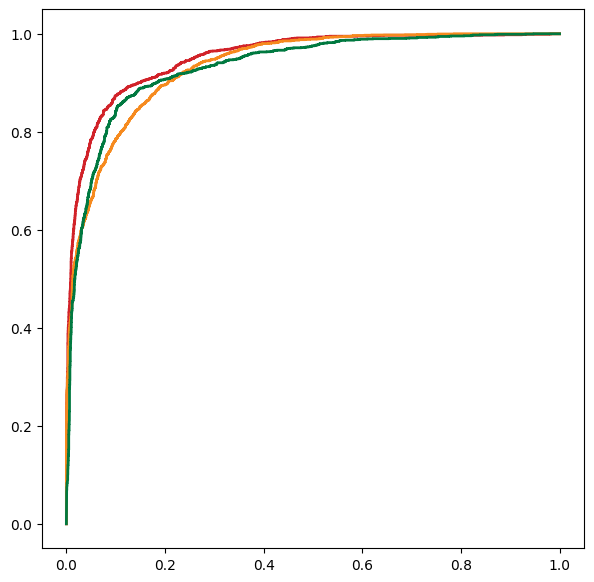

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import torch

backbone = models.resnet50(pretrained=True)
num_features = backbone.fc.in_features
backbone.fc = nn.Linear(num_features, 2)  # Binary classification: target vs non-target

for name, param in backbone.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
# model_resnet = backbone.to(device)
# model_resnet.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_resnet50.pth"))


model_resnet_100ep= backbone.to(device)
model_resnet_100ep.load_state_dict(torch.load(f"{MODELS_DIR}/best_recall_model_resnet50_100ep.pth",map_location=device))


model_facecnn = FaceCNN(num_classes=2, img_height=170, img_width=220).to(device)
# Load a checkpoint, e.g., best_accuracy_model.pth
model_facecnn.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_faceCNN.pth", map_location=device))


model_mlp = SimpleMLP().to(device)
model_mlp.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_simpleMLP.pth", map_location=device))


models_to_compare = [
    (model_facecnn, "FaceCNN Best Recall 50 ep"),
    (model_resnet_100ep, "ResNet50 Best Recall 100 ep"),
    (model_mlp, "Simple MLP 50 ep"),
    (ref_model_200, "One-shot 200 train refs"),
    (ref_model_all, "One-shot ALL train refs"),
]

colors = ["#d12229", "#f68a1e", "#007940", "#24408e", "#732982", "#8a4b2e"]


plt.figure(figsize=(7,7))

for idx, (model, name) in enumerate(models_to_compare):
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            if isinstance(model, torch.nn.Module):
                model.eval()
                model.to(device)

                outputs = model(images)
                if outputs.shape[1] == 2:  
                    probs = torch.softmax(outputs, dim=1)[:, 1]  # prob of positive class
                else:
                    probs = torch.sigmoid(outputs).squeeze(1)

                all_probs.extend(probs.cpu().numpy())
            else:
                scores = model.predict_proba(images)  # already numpy
                all_probs.extend(scores)

            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2,
             label=f"{name} (AUC = {roc_auc:.5f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curves_resnet_vs_facecnn_vs_mlp_vs_refs.png", dpi=300)
plt.show()




In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import torch
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

backbone = models.resnet50(pretrained=True)
num_features = backbone.fc.in_features
backbone.fc = nn.Linear(num_features, 2)  # Binary classification: target vs non-target

for name, param in backbone.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
# model_resnet = backbone.to(device)
# model_resnet.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_resnet50.pth"))


model_resnet_100ep= backbone.to(device)
model_resnet_100ep.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_resnet50_100ep.pth",map_location=device))


model_facecnn = FaceCNN(num_classes=2, img_height=170, img_width=220).to(device)
# Load a checkpoint, e.g., best_accuracy_model.pth
model_facecnn.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_faceCNN.pth", map_location=device))


model_mlp = SimpleMLP().to(device)
model_mlp.load_state_dict(torch.load(f"{MODELS_DIR}/best_precision_model_simpleMLP.pth", map_location=device))


models_to_compare = [
    (model_facecnn, "FaceCNN Best Recall 50 ep"),
    (model_resnet_100ep, "ResNet50 Best Recall 100 ep"),
    (model_mlp, "Simple MLP 50 ep"),
    (ref_model_200, "One-shot 200 train refs"),
    (ref_model_all, "One-shot ALL train refs"),
]

colors = ["#d12229", "#f68a1e", "#007940", "#24408e", "#732982", "#8a4b2e"]


In [ ]:
import os
import pandas as pd
import json
from tqdm import tqdm

save_dir = "predictions"
os.makedirs(save_dir, exist_ok=True)

all_model_results = {}

for idx, (model, name) in enumerate(models_to_compare):
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {name}"):
            images, labels = images.to(device), labels.to(device)

            if isinstance(model, torch.nn.Module):
                model.eval()
                model.to(device)

                outputs = model(images)
                if outputs.shape[1] == 2:  
                    probs = torch.softmax(outputs, dim=1)  # shape (batch, 2)
                    prob_positive = probs[:, 1].cpu().numpy()
                    prob_negative = probs[:, 0].cpu().numpy()
                else:
                    prob_positive = torch.sigmoid(outputs).squeeze(1).cpu().numpy()
                    prob_negative = 1 - prob_positive

                all_probs.extend(list(zip(prob_negative, prob_positive)))
            else:
                prob_positive = model.predict_proba(images)  # numpy array of [0,1]
                prob_negative = 1 - prob_positive
                all_probs.extend(list(zip(prob_negative, prob_positive)))

            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)  # shape (N, 2)
    y_pred = np.argmax(all_probs, axis=1)

    
    df = pd.DataFrame({
        "true_label": all_labels,
        "pred_label": y_pred,
        "prob_non_target": all_probs[:, 0],
        "prob_target": all_probs[:, 1]
    })

    # save csv needed for graphs
    csv_path = os.path.join(save_dir, f"{name.replace(' ','_')}_test_predictions.csv")
    df.to_csv(csv_path, index=False)
    print(f"[✓] Saved CSV for {name}: {csv_path}")

    # save to dict for JSON
    all_model_results[name] = df.to_dict(orient="list")

# save all models predictions to one JSON file
json_path = os.path.join(save_dir, "all_models_test_predictions.json")
with open(json_path, "w") as f:
    json.dump(all_model_results, f)

print(f"[✓] Saved all model predictions to JSON: {json_path}")


Evaluating FaceCNN Best Recall 50 ep: 100%|██████████████████████████████████████████| 181/181 [01:55<00:00,  1.56it/s]


[✓] Saved CSV for FaceCNN Best Recall 50 ep: predictions\FaceCNN_Best_Recall_50_ep_test_predictions.csv


Evaluating ResNet50 Best Recall 100 ep: 100%|████████████████████████████████████████| 181/181 [06:31<00:00,  2.16s/it]


[✓] Saved CSV for ResNet50 Best Recall 100 ep: predictions\ResNet50_Best_Recall_100_ep_test_predictions.csv


Evaluating Simple MLP 50 ep: 100%|███████████████████████████████████████████████████| 181/181 [00:23<00:00,  7.79it/s]


[✓] Saved CSV for Simple MLP 50 ep: predictions\Simple_MLP_50_ep_test_predictions.csv


Evaluating One-shot 200 train refs: 100%|████████████████████████████████████████████| 181/181 [07:57<00:00,  2.64s/it]


[✓] Saved CSV for One-shot 200 train refs: predictions\One-shot_200_train_refs_test_predictions.csv


Evaluating One-shot ALL train refs: 100%|████████████████████████████████████████████| 181/181 [10:27<00:00,  3.47s/it]


[✓] Saved CSV for One-shot ALL train refs: predictions\One-shot_ALL_train_refs_test_predictions.csv
[✓] Saved all model predictions to JSON: predictions\all_models_test_predictions.json


In [ ]:
model_resnet_100ep = backbone.to(device)
model_resnet_100ep.load_state_dict(
    torch.load(f"{MODELS_DIR}/best_precision_model_resnet50_100ep.pth", map_location=device)
)
model_resnet_100ep.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating ResNet50 Best Precision"):
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet_100ep(images)
        probs = torch.softmax(outputs, dim=1)  # (batch, 2)
        prob_positive = probs[:, 1].cpu().numpy()
        prob_negative = probs[:, 0].cpu().numpy()
        all_probs.extend(list(zip(prob_negative, prob_positive)))
        all_labels.extend(labels.cpu().numpy())

import pandas as pd
import os
save_dir = "predictions"
os.makedirs(save_dir, exist_ok=True)

df = pd.DataFrame({
    "true_label": all_labels,
    "prob_non_target": [p[0] for p in all_probs],
    "prob_target": [p[1] for p in all_probs],
    "pred_label": [int(np.argmax(p)) for p in all_probs]
})

csv_path = os.path.join(save_dir, "ResNet50_Best_Precision_test_predictions.csv")
df.to_csv(csv_path, index=False)


Evaluating ResNet50 Best Precision: 100%|████████████████████████████████████████████| 181/181 [09:58<00:00,  3.31s/it]


In [ ]:
import json
import pandas as pd
import numpy as np
import os

save_dir = "predictions"
json_path = os.path.join(save_dir, "all_models_test_predictions.json")

if os.path.exists(json_path):
    with open(json_path, "r") as f:
        all_model_results = json.load(f)
else:
    all_model_results = {}

model_name = "ResNet50 Best Precision"
all_model_results[model_name] = df.to_dict(orient="list")

with open(json_path, "w") as f:
    json.dump(all_model_results, f, indent=4)

print(f"Updated JSON with {model_name}")


[✓] Updated JSON with ResNet50 Best Precision


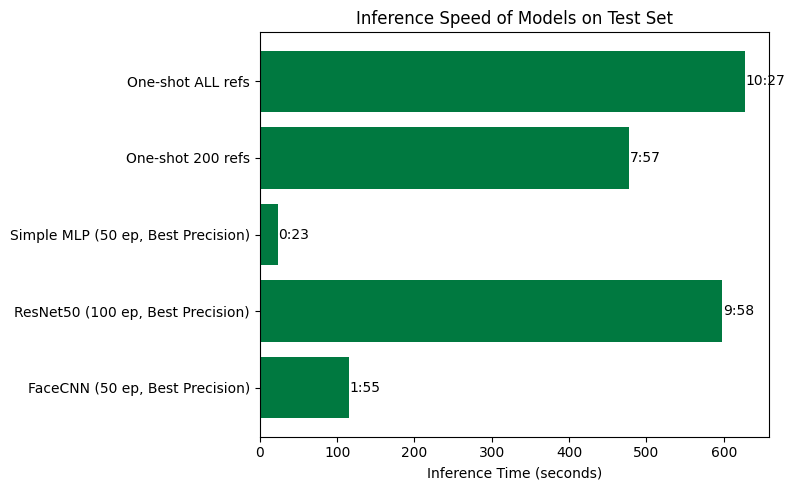

In [ ]:
import matplotlib.pyplot as plt

models = [
    "FaceCNN (50 ep, Best Precision)",
    "ResNet50 (100 ep, Best Precision)",
    "Simple MLP (50 ep, Best Precision)",
    "One-shot 200 refs",
    "One-shot ALL refs"
]

times_str = ["1:55", "9:58", "0:23", "7:57", "10:27"]

# convert to seconds
times_sec = []
for t in times_str:
    mins, secs = map(int, t.split(":"))
    times_sec.append(mins*60 + secs)

plt.figure(figsize=(8,5))
bars = plt.barh(models, times_sec, color="#007940")
plt.xlabel("Inference Time (seconds)")
plt.title("Inference Speed of Models on Test Set")

for bar, t in zip(bars, times_str):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, t, va='center')


plt.tight_layout()
plt.savefig("inference_speed.png")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import json

with open("predictions/all_models_test_predictions.json") as f:
    all_model_results = json.load(f)

metrics_results = {}

for name, preds_dict in all_model_results.items():
    y_true = np.array(preds_dict["true_label"])
    y_pred = np.array(preds_dict["pred_label"])
    y_prob = np.array(preds_dict["prob_target"])  

    metrics_results[name] = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_prob)
    }

metrics_df = pd.DataFrame(metrics_results).T
print(metrics_df)


                             accuracy  precision    recall        f1       auc
FaceCNN Best Recall 50 ep    0.884954   0.912989  0.736341  0.815205  0.952490
ResNet50 Best Recall 100 ep  0.859388   0.801737  0.786466  0.794028  0.934835
Simple MLP 50 ep             0.865953   0.866506  0.722306  0.787862  0.932984
One-shot 200 train refs      0.344619   0.344619  1.000000  0.512590  0.837509
One-shot ALL train refs      0.344619   0.344619  1.000000  0.512590  0.835113
ResNet50 Best Precision      0.861461   0.862174  0.711779  0.779791  0.938535


FaceCNN Best Recall 50 ep
ResNet50 Best Recall 100 ep
Simple MLP 50 ep
One-shot 200 train refs
One-shot ALL train refs
ResNet50 Best Precision


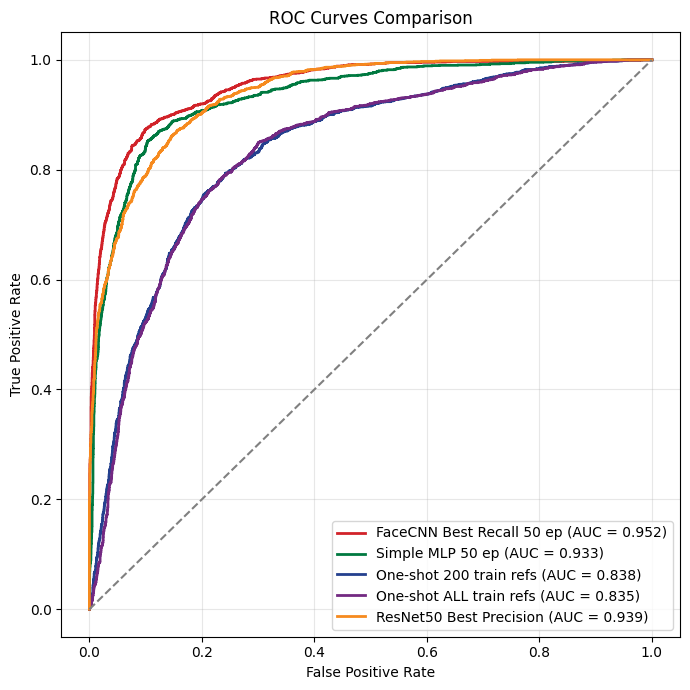

In [71]:
plt.figure(figsize=(7,7))
colors = ["#d12229", "#f68a1e", "#007940", "#24408e", "#732982", '#f68a1e' ,"#8a4b2e"]

for idx, (name, preds_dict) in enumerate(all_model_results.items()):
    print(name)
    if name == "ResNet50 Best Recall 100 ep":
        continue
    y_true = np.array(preds_dict["true_label"])
    y_prob = np.array(preds_dict["prob_target"])  # probability of positive class

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2,
             label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("ROC_CURVES_FINAL.png")
plt.show()


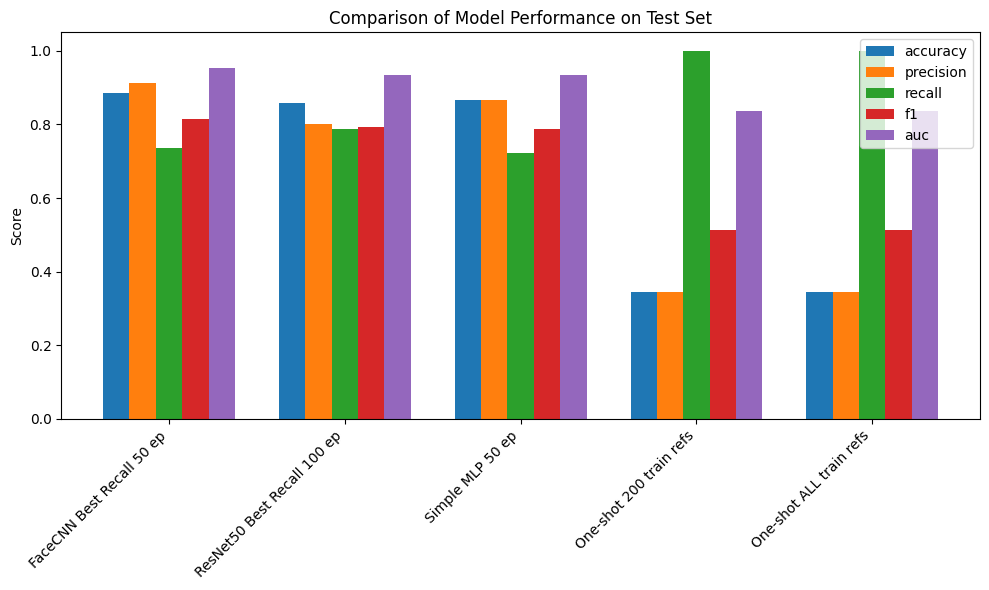

In [ ]:
metrics_to_plot = ["accuracy", "precision", "recall", "f1", "auc"]

plt.figure(figsize=(10,6))
x = np.arange(len(metrics_df))  
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*width, metrics_df[metric], width=width, label=metric)

plt.xticks(x + width*2, metrics_df.index, rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Comparison of Model Performance on Test Set")
plt.ylim(0,1.05)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

results = {
    "model": [],
    "image_idx": [],
    "true_label": [],
    "pred_label": [],
    "prob": [],
}

THRESHOLD = 0.5

for idx_model, (model, name) in enumerate(models_to_compare):
    all_labels = []
    all_probs = []
    fp_indices = []
    fn_indices = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            if isinstance(model, torch.nn.Module):
                model.eval()
                model.to(device)

                outputs = model(images)
                if outputs.shape[1] == 2:  
                    probs = torch.softmax(outputs, dim=1)[:, 1]  # prob of positive class
                else:
                    probs = torch.sigmoid(outputs).squeeze(1)

                preds = (probs > THRESHOLD).long()
                all_probs.extend(probs.cpu().numpy())
            else:
                probs = model.predict_proba(images)  # numpy
                preds = (probs > THRESHOLD).astype(int)
                all_probs.extend(probs)

            labels_np = labels.cpu().numpy()
            all_labels.extend(labels_np)

            # Identify FP and FN indices within this batch
            for i in tqdm(range(len(labels_np))):
                if labels_np[i] == 0 and preds[i] == 1:  # false positive
                    fp_indices.append(batch_idx * test_loader.batch_size + i)
                elif labels_np[i] == 1 and preds[i] == 0:  # false negative
                    fn_indices.append(batch_idx * test_loader.batch_size + i)

                # Store results for possible CSV export
                results["model"].append(name)
                results["image_idx"].append(batch_idx * test_loader.batch_size + i)
                results["true_label"].append(labels_np[i])
                results["pred_label"].append(preds[i])
                results["prob"].append(probs[i])

    print(f"{name} - FP: {len(fp_indices)}, FN: {len(fn_indices)}")

# Save full results to CSV
df = pd.DataFrame(results)
df.to_csv("predictions_with_probs.csv", index=False)
print("Saved predictions, including false positives and false negatives, to predictions_with_probs.csv")


100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 29057.53it/s]


FaceCNN Best Recall 50 ep - FP: 140, FN: 526


100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32032.87it/s]
Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 176, in zmq.backend.cython._zmq._check_rc
    PyErr_CheckSignals()
^^^^^^^^^^^
KeyboardInterrupt: 


KeyboardInterrupt: 

Accuracy:  0.6376
Recall:    0.9431
Precision: 0.6092
F1 Score:  0.7402


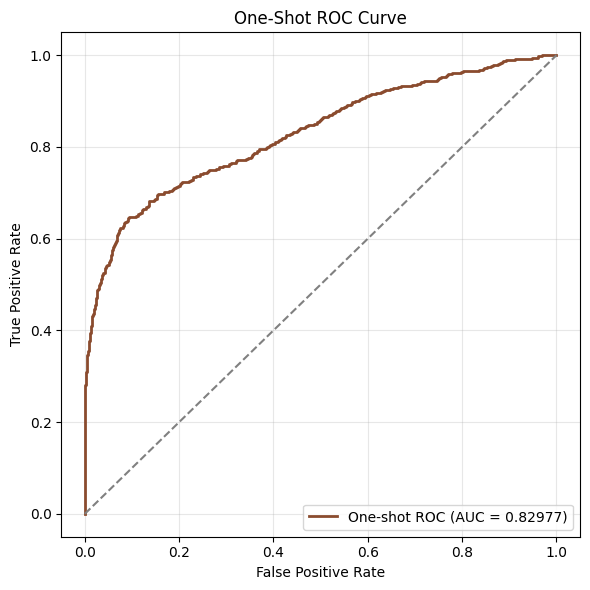

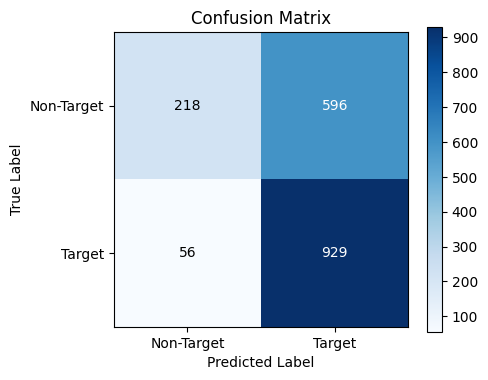

In [176]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

backbone = models.resnet50(pretrained=True)
backbone.fc = nn.Identity()  # get embeddings instead of class logits
model = backbone.to(device)
model.eval()

def get_embedding_tensor(img_tensor):
    """ img_tensor: (B, C, H, W) already on device """
    with torch.no_grad():
        emb = model(img_tensor)
    return emb

ref_path = "data/train/target_person/cropped_face_1198.jpg"
ref_img = Image.open(ref_path).convert("RGB")
ref_tensor = val_tfms(ref_img).unsqueeze(0).to(device)
ref_emb = get_embedding_tensor(ref_tensor).cpu().numpy()

threshold = 0.8
all_labels, all_preds, all_scores = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        batch_embs = get_embedding_tensor(images).cpu().numpy()
        sims = cosine_similarity(ref_emb, batch_embs)[0]  # shape (batch,)
        preds = (sims >= threshold).astype(int)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_scores.extend(sims)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_scores = np.array(all_scores)

acc = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy:  {acc:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score:  {f1:.4f}")

fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='#8a4b2e', lw=2, label=f'One-shot ROC (AUC = {roc_auc:.5f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-Shot ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_labels, all_preds)
classes = ["Non-Target", "Target"]

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [185]:
import random
from torch.utils.data import Subset

def get_embeddings_from_loader(loader, max_samples=None):
    embs, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            batch_embs = get_embedding_tensor(imgs).cpu().numpy()
            embs.append(batch_embs)
            labels.extend(lbls.numpy())

            if max_samples is not None and len(labels) >= max_samples:
                break

    embs = np.vstack(embs)
    labels = np.array(labels)
    return embs, labels

# 200 random images from train set
indices_200 = random.sample(range(len(train_dataset)), 200)
train_subset_200 = Subset(train_dataset, indices_200)
train_loader_200 = torch.utils.data.DataLoader(train_subset_200, batch_size=32, shuffle=False)

ref_embs_200, _ = get_embeddings_from_loader(train_loader_200)

# All training images
train_loader_full = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
ref_embs_all, _ = get_embeddings_from_loader(train_loader_full)

print(f"Ref set 200 shape: {ref_embs_200.shape}, Ref set ALL shape: {ref_embs_all.shape}")


Ref set 200 shape: (200, 2048), Ref set ALL shape: (4856, 2048)
